In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
vocab = catalog.load('dictionary')
train_docs = catalog.load('train_docs')
train_corpus = catalog.load('train_corpus')

2020-04-03 11:08:04,212 - kedro.io.data_catalog - INFO - Loading data from `dictionary` (DictionaryDataSet)...
2020-04-03 11:08:04,213 - gensim.utils - INFO - loading Dictionary object from data/05_model_input/dictionary.dict
2020-04-03 11:08:04,215 - gensim.utils - INFO - loaded data/05_model_input/dictionary.dict
2020-04-03 11:08:04,215 - kedro.io.data_catalog - INFO - Loading data from `train_docs` (PickleLocalDataSet)...
2020-04-03 11:08:04,419 - kedro.io.data_catalog - INFO - Loading data from `train_corpus` (MmCorpusDataSet)...
2020-04-03 11:08:04,421 - gensim.corpora.indexedcorpus - INFO - loaded corpus index from data/05_model_input/train_corpus.mm.index
2020-04-03 11:08:04,422 - gensim.corpora._mmreader - INFO - initializing cython corpus reader from data/05_model_input/train_corpus.mm
2020-04-03 11:08:04,423 - gensim.corpora._mmreader - INFO - accepted corpus with 15078 documents, 2715 features, 1054084 non-zero entries


## Get model

In [3]:
#import gensim.downloader as api
#model = api.load("glove-twitter-25")

from gensim.models import Word2Vec
w2v = Word2Vec.load('./data/04_features/word2vec_model.bin')

2020-04-03 11:08:05,046 - gensim.utils - INFO - loading Word2Vec object from ./data/04_features/word2vec_model.bin
2020-04-03 11:08:05,153 - gensim.utils - INFO - loading wv recursively from ./data/04_features/word2vec_model.bin.wv.* with mmap=None
2020-04-03 11:08:05,154 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2020-04-03 11:08:05,155 - gensim.utils - INFO - loading vocabulary recursively from ./data/04_features/word2vec_model.bin.vocabulary.* with mmap=None
2020-04-03 11:08:05,155 - gensim.utils - INFO - loading trainables recursively from ./data/04_features/word2vec_model.bin.trainables.* with mmap=None
2020-04-03 11:08:05,156 - gensim.utils - INFO - setting ignored attribute cum_table to None
2020-04-03 11:08:05,156 - gensim.utils - INFO - loaded ./data/04_features/word2vec_model.bin


In [4]:
len(w2v.wv.vocab), w2v.vector_size

(4895, 300)

In [5]:
w2v.most_similar('war')

2020-04-03 11:08:06,411 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('world_war', 0.4436487555503845),
 ('gulf', 0.4100189208984375),
 ('massacre', 0.4027578830718994),
 ('serb', 0.36117807030677795),
 ('britain', 0.34083133935928345),
 ('bosnian', 0.33297497034072876),
 ('ottoman', 0.3318420648574829),
 ('jew', 0.32354503870010376),
 ('arab', 0.3178195655345917),
 ('muslim', 0.31602174043655396)]

In [6]:
war = w2v['war'].reshape((1, -1))
cold = w2v['gulf'].reshape((1, -1))
w2v.similarity('gulf', 'war')
cosine_similarity(cold, war)

/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.41001892]], dtype=float32)

## Train model: clustering in word space

In [7]:
from sklearn import preprocessing

In [8]:
words = list(vocab.token2id)
words = [w for w in words if w in w2v.wv.vocab]

embeddings = np.array([w2v[w] for w in words])
embeddings_norm = preprocessing.normalize(embeddings)

dict = {w:emb for w,emb in zip(words, embeddings_norm)}

/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [9]:
from sklearn.cluster import KMeans

In [10]:
count_dict = {w:0 for w in words}
for doc in train_docs:
    for w in doc:
        count_dict[w] += 1
weights = np.array([count_dict[w] for w in words])

In [11]:
num_topics = 15
#model = KMeans(n_clusters=num_topics).fit(embeddings_norm)
model = KMeans(n_clusters=num_topics).fit(embeddings_norm, sample_weight=weights)

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
vocab_size = len(vocab)
beta = np.zeros((num_topics, vocab_size))

#preds = model.predict(embeddings_norm)
preds = model.predict(embeddings_norm, sample_weight=weights)
preds = preds.reshape((-1, 1))
enc = OneHotEncoder(handle_unknown='ignore').fit(preds)

similarities = np.zeros((num_topics, vocab_size))

wvs = np.array([dict[w] for w in vocab.token2id])
wvs = wvs.reshape((vocab_size, -1))
for k in range(num_topics):
    cluster_center = model.cluster_centers_[k].reshape((1, -1))
    similarities[k] = cosine_similarity(cluster_center, wvs)
    
beta = enc.transform(preds).toarray().T
beta = beta * similarities
beta = beta / beta.sum(axis=1, keepdims=True)

In [30]:
theta = []
for doc in train_docs:
    word_vectors = np.array([dict[w] for w in doc])
    preds = model.predict(word_vectors)
    tmp = enc.transform(preds.reshape((-1, 1))).toarray().mean(axis=0)
    theta.append(tmp)
theta = np.array(theta)

## Eval model

In [42]:
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import MDS

def extract_top_n_words(topic_distributions, dictionary, topic_id, top_n):
    top_n_words = [dictionary[np.argsort(topic_distributions[topic_id])[-i-1]] for i in range(top_n)]
    top_n_freqs = [np.sort(topic_distributions[topic_id])[-i-1] for i in range(top_n)]
    return top_n_words, top_n_freqs

def calculate_topic_distances(topic_distributions):
    num_topics = len(topic_distributions)
    distances = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            topic_i, topic_j = topic_distributions[i], topic_distributions[j]
            distances[i][j] = jensenshannon(topic_i, topic_j)
    return distances

def show_most_m_represantative_docs(doc_topic, m, docs, topic_id):
    indices_max = np.argsort(doc_topic[:,topic_id])[-m:]
    verbatims = []
    for idx in reversed(indices_max):
        doc = docs[idx]
        verbatims.append(' '.join(list(doc)))
    return verbatims

def occ_dict(doc):
    occurences_dict = {}
    for word in doc:
        if word in occurences_dict:
            occurences_dict[word] += 1
        else:
            occurences_dict[word] = 1
    return occurences_dict

def get_Dwi(wi, doc_dicts):
    Dwi = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict:
            Dwi += doc_dict[wi]
    return Dwi

def get_Dwiwj(wi, wj, doc_dicts):
    Dwiwj = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict and wj in doc_dict:
            Dwiwj += doc_dict[wi] * doc_dict[wj]
    return Dwiwj

def topic_coherence(topic_distributions, dictionary, topic_id, top_n, docs, method='umass', eps=1e-5):
    top_words, _ = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n)

    N = top_n - 1

    D = 0
    for doc in docs:
        D += len(doc)
    #D = len(docs)

    # remplacer par un CountVectorizer
    doc_dicts = [occ_dict(doc) for doc in docs]

    score = 0.
    for i in range(1, N):
        for j in range(i):
            wi = top_words[i]
            wj = top_words[j]

            Dwj = get_Dwi(wj, doc_dicts)
            Dwiwj = get_Dwiwj(wi, wj, doc_dicts)

            pwj = Dwj / D
            pwiwj = Dwiwj / D

            # umass
            if method == 'umass':
                score += np.log((pwiwj + eps) / pwj)

            # pmi
            elif method == 'pmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D
                score += np.log((pwiwj + eps) / (pwi * pwj))

            # npmi
            elif method == 'npmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D

                if Dwiwj == 0:
                    score += -1.
                elif Dwiwj == Dwi and Dwiwj == Dwj:
                    score += 1.
                else:
                    score += np.log((pwiwj + eps) / (pwi * pwj)) / (- np.log(pwiwj + eps))

    return score / (2 * N * (N - 1))

def topic_diversity(topic_distributions, dictionary, top_n):
    top_words = []
    num_topics = len(topic_distributions)
    for k in range(num_topics):
        tmp, _ = extract_top_n_words(topic_distributions, dictionary, k, top_n)
        top_words += tmp
    return len(np.unique(top_words)) / len(top_words)

def eval_model(topic_distributions, doc_topic_matrix, dictionary, train_docs,
               num_topics, top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25):

    # Metrics

    ## Qualitative Metrics

    ### Top-n words per topic
    for topic_id in range(num_topics):
        top_n_words, top_n_freqs = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n_show)

        plt.figure(figsize=(10, 4))
        plt.title('Topic number ' + str(topic_id))
        plt.bar(top_n_words, top_n_freqs)
        plt.show()

    ### Topic sizes
    #

    ### Topic distances
    distances = calculate_topic_distances(topic_distributions)
    plt.figure(figsize=(6, 6))
    plt.imshow(distances, cmap='Greys')
    plt.show()

    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(distances).embedding_
    plt.figure(figsize=(6, 6))
    plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0)
    plt.show()

    ### Most m representative documents
    for topic_id in range(num_topics):
        print('Topic number ', topic_id, show_most_m_represantative_docs(doc_topic_matrix, m_most, train_docs, topic_id))


    ## Quantitative Metrics

    ### Topic Coherence
    mean_tc = 0.
    for topic_id in range(num_topics):
        tc = topic_coherence(topic_distributions, dictionary, topic_id, top_n_coherence, train_docs, method='npmi')
        print('Topic number ', topic_id, 'tc:', tc)
        mean_tc += tc
    print('Topic coherence:', mean_tc / num_topics)

    ### Topic Diversity
    print('Topic diversity', topic_diversity(topic_distributions, dictionary, top_n_diversity))

    ### Predictive Quality
    #

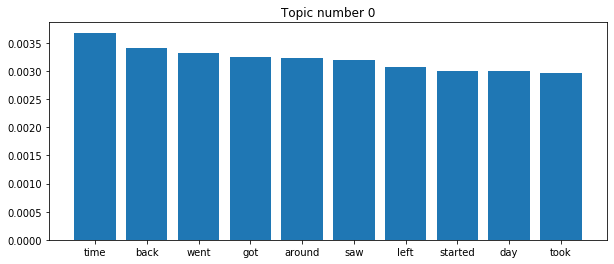

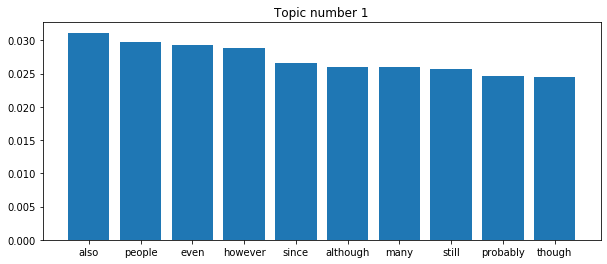

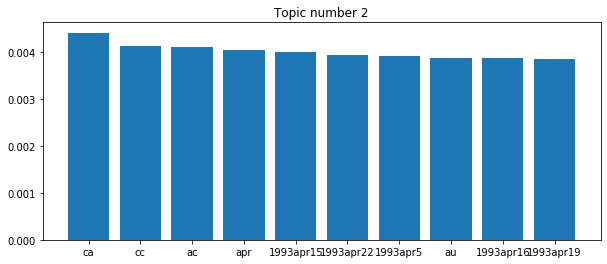

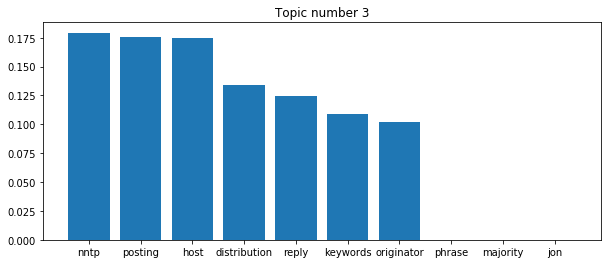

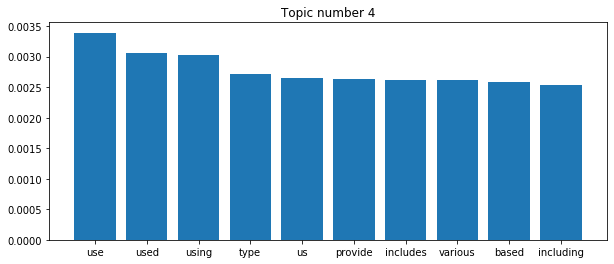

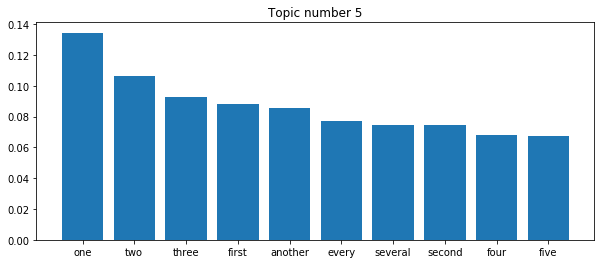

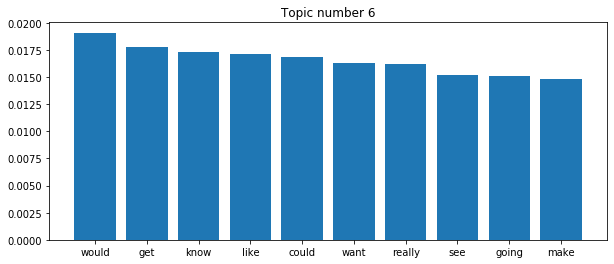

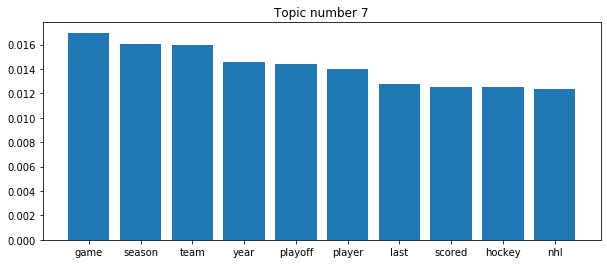

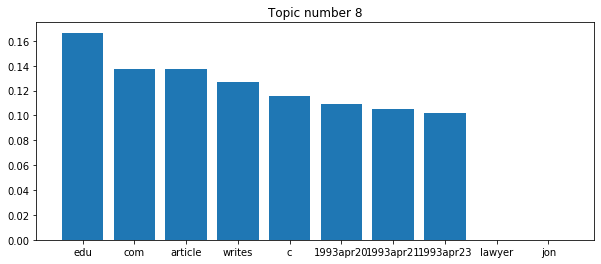

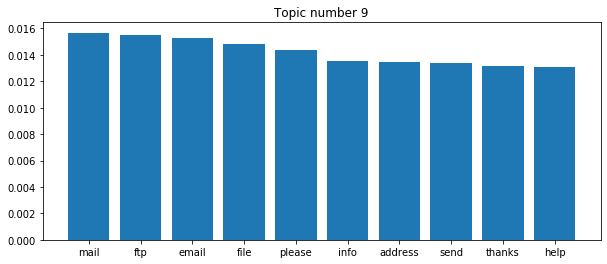

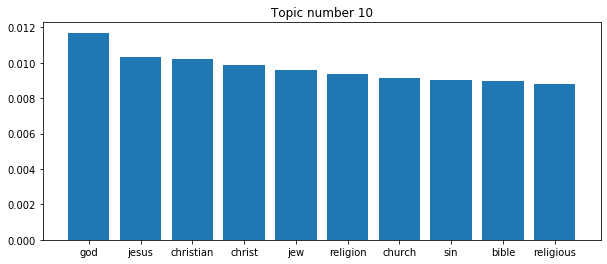

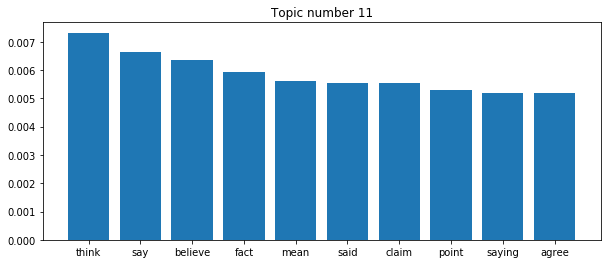

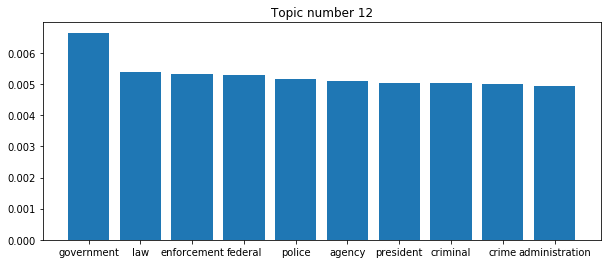

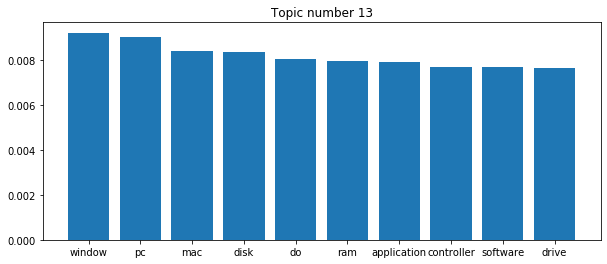

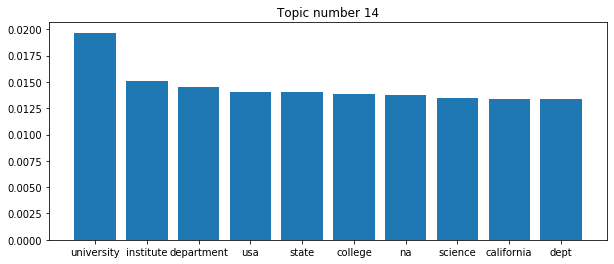

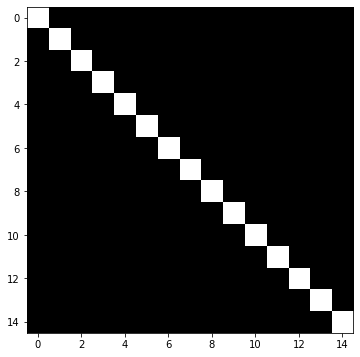

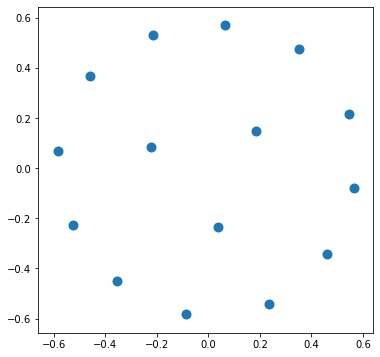

Topic number  0 ['org dog v bike inc tx first dog bike first run big german ran pack bike riding tried right leg guy riding front dog couple time going made dog got away dog started truly time open hell soon dog foot away right side bike pulled motor dog away probably made dog hurt like hell come back rest behind either second already road kill dog paying close attention car front looked time see run held onto wheel went dog like running piece bike lose kept going got found bit blood stuck bottom motor frame dod inc tx org std disclaimer opinion mine let u learn dream perhaps shall learn truth august']
Topic number  1 ['st com speaking corporation writes well alone conflict even arab speaking seem hate least much anyone else perhaps israel killing people perhaps arab even speaking']
Topic number  2 ['sun csd ca rocket nhl playoff leader penalty april university new distribution rec sport hockey player team pt thomas la brown van mon van van robert young nj van adam van van king win la 

Topic number  0 tc: 0.276451142746388
Topic number  1 tc: 0.2518268278092869
Topic number  2 tc: 0.09064456358310234
Topic number  3 tc: 0.15624088744179077
Topic number  4 tc: 0.2584336899308678
Topic number  5 tc: 0.2507555628314948
Topic number  6 tc: 0.2892286437159664
Topic number  7 tc: 0.29811058130046714
Topic number  8 tc: 0.1806731904521018
Topic number  9 tc: 0.29972939194891657
Topic number  10 tc: 0.29131230518653317
Topic number  11 tc: 0.2661070573268602
Topic number  12 tc: 0.25468233936959717
Topic number  13 tc: 0.37612362332759247
Topic number  14 tc: 0.17052576661641625
Topic coherence: 0.2473897049058254
Topic diversity 0.9146666666666666


In [43]:
eval_model(beta, theta, vocab, train_docs, num_topics, 
           top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25)

In [47]:
for i,x in enumerate(model.cluster_centers_):
    res = [words[w] for w in np.argsort(cosine_similarity(embeddings, x.reshape((1, -1))), axis=0).T[0][-20:]]
    res.reverse()
    print('Topic number ', i, res)
    #print(model.similar_by_vector(x, topn=10))

Topic number  0 ['one', 'time', 'back', 'went', 'got', 'around', 'saw', 'going', 'get', 'left', 'started', 'day', 'took', 'even', 'still', 'came', 'would', 'three', 'bike', 'like']
Topic number  1 ['also', 'people', 'even', 'however', 'one', 'since', 'although', 'many', 'still', 'probably', 'would', 'though', 'think', 'may', 'thus', 'least', 'either', 'seem', 'simply', 'quite']
Topic number  2 ['edu', 'com', 'article', 'ca', 'host', 'c', 'nntp', 'cc', '1993apr20', 'ac', 'writes', 'apr', 'posting', '1993apr21', '1993apr15', '1993apr22', '1993apr5', 'au', 'university', '1993apr16']
Topic number  3 ['nntp', 'posting', 'host', 'distribution', 'reply', 'article', 'keywords', 'university', 'edu', 'na', 'originator', 'newsreader', '1993apr20', '1993apr22', '1993apr5', '1993apr19', 'com', '1993apr23', '1993apr16', '1993apr21']
Topic number  4 ['use', 'also', 'used', 'using', 'one', 'type', 'us', 'however', 'provide', 'includes', 'various', 'based', 'including', 'set', 'since', 'available', 'ap

## Visualize clusters

In [ ]:
from sklearn.manifold import TSNE
#X_embedded = TSNE(n_components=2, metric='cosine').fit_transform(embeddings)
X_embedded = TSNE(n_components=2).fit_transform(embeddings_norm)
Y_embedded = model.predict(embeddings_norm)
plt.figure(figsize=(20, 20))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=Y_embedded, s=20)
plt.show()

## Aside: choose k (elbow method, silhouette score)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


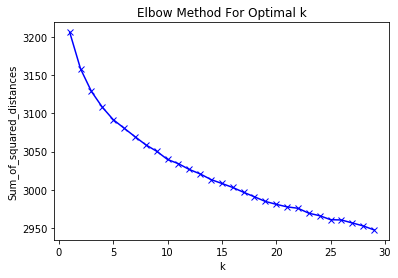

In [29]:
sum_of_squared_distances = []
range_n_clusters = [int(k) for k in range(1, 30)]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(range_n_clusters, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.014058579
For n_clusters = 3 The average silhouette_score is : 0.013450489
For n_clusters = 4 The average silhouette_score is : 0.013307613
For n_clusters = 5 The average silhouette_score is : 0.012729318
For n_clusters = 6 The average silhouette_score is : 0.012469433
For n_clusters = 7 The average silhouette_score is : 0.012167494
For n_clusters = 8 The average silhouette_score is : 0.012453614
For n_clusters = 9 The average silhouette_score is : 0.012341245
For n_clusters = 10 The average silhouette_score is : 0.011161342
For n_clusters = 11 The average silhouette_score is : 0.011375577
For n_clusters = 12 The average silhouette_score is : 0.011544396
For n_clusters = 13 The average silhouette_score is : 0.011115901
For n_clusters = 14 The average silhouette_score is : 0.010674976


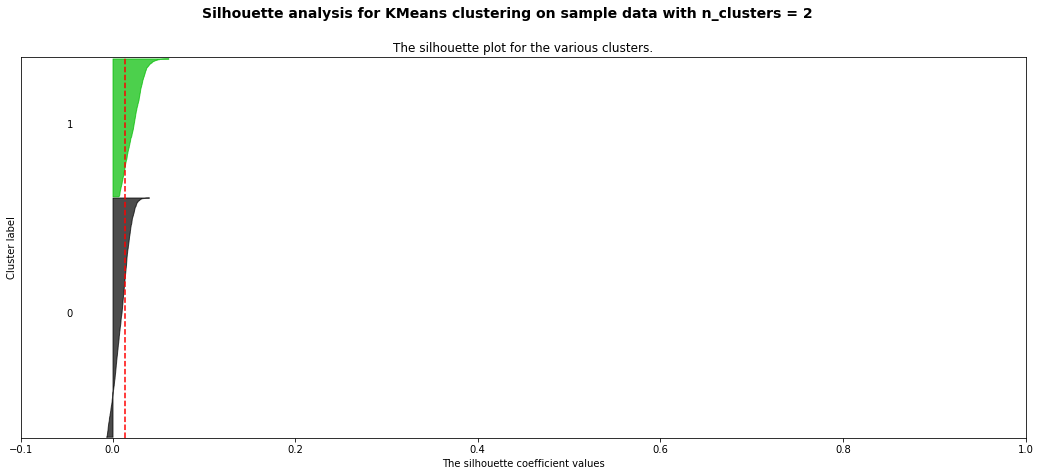

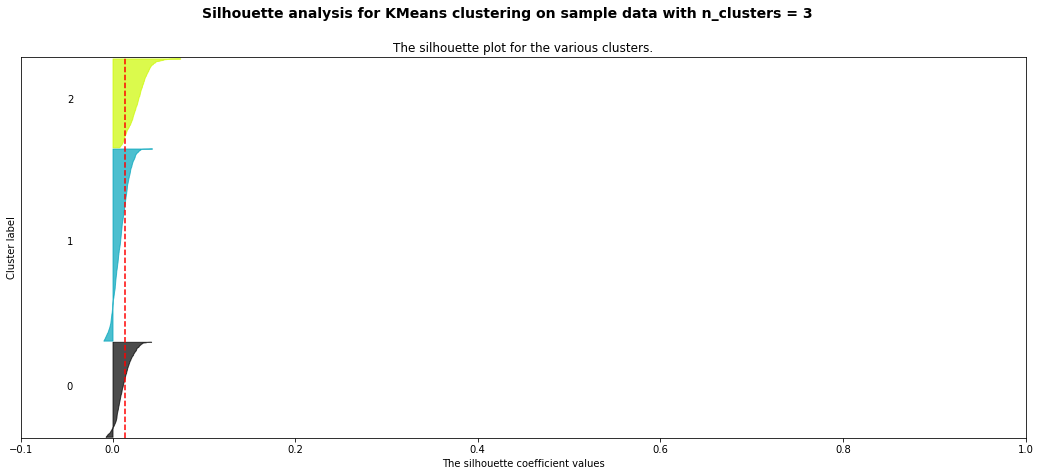

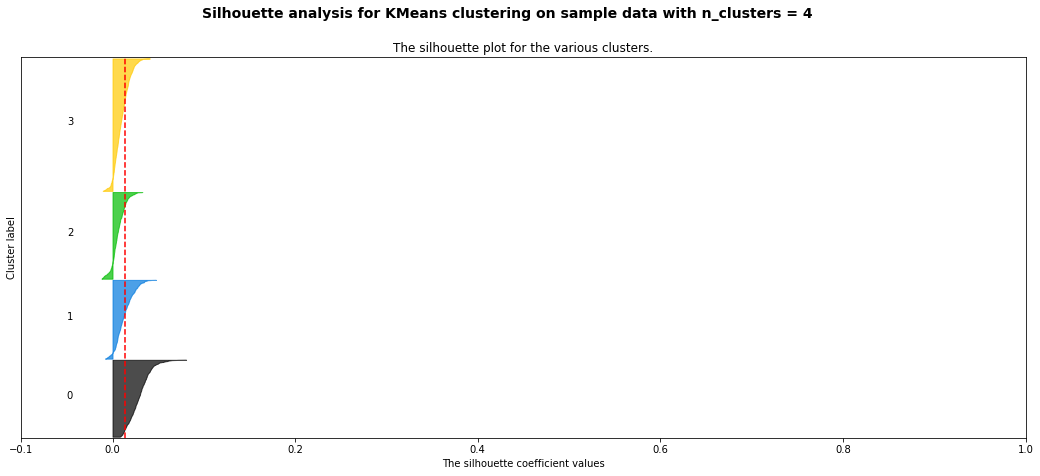

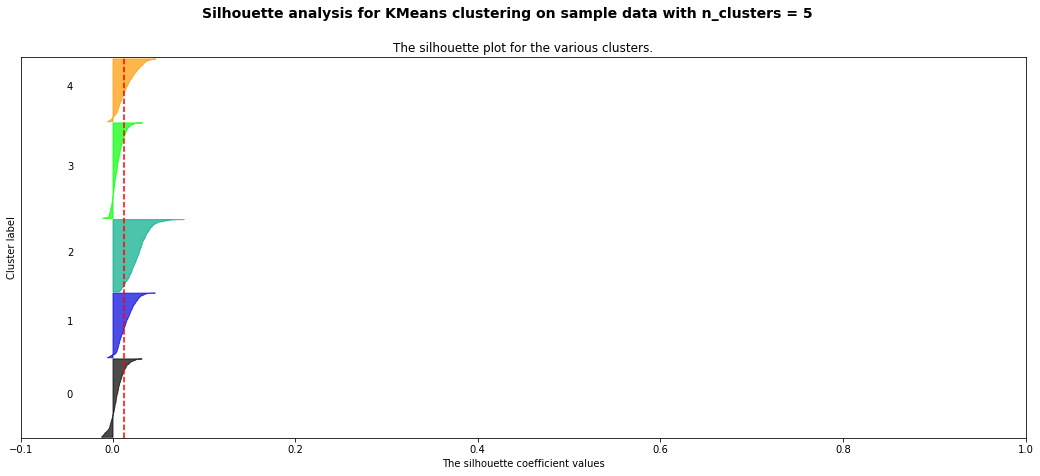

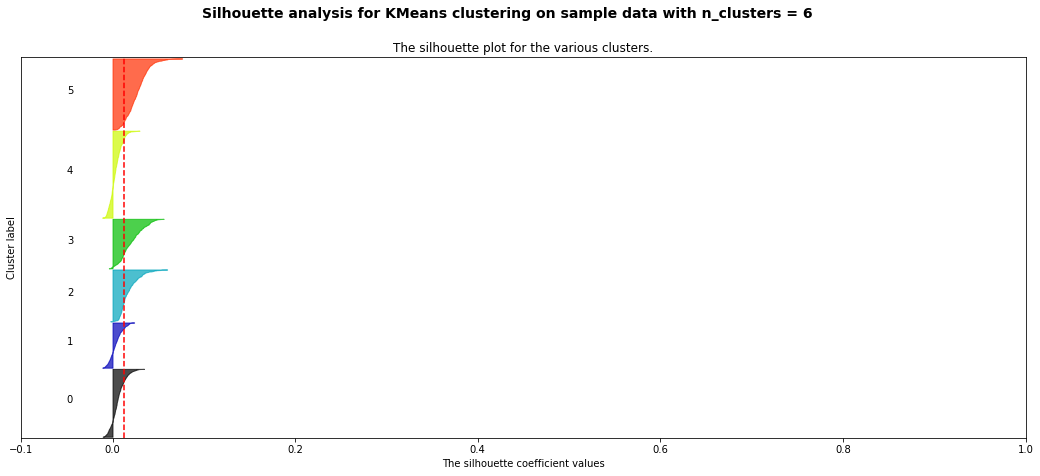

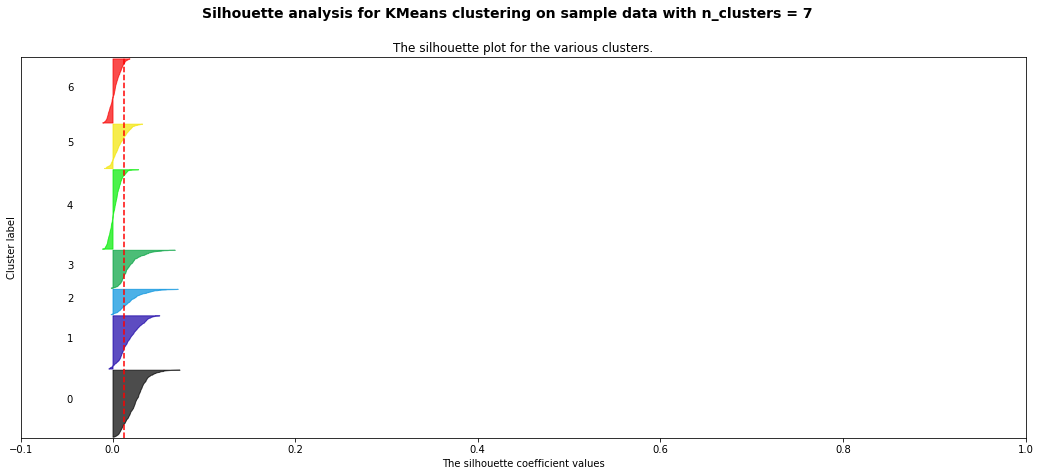

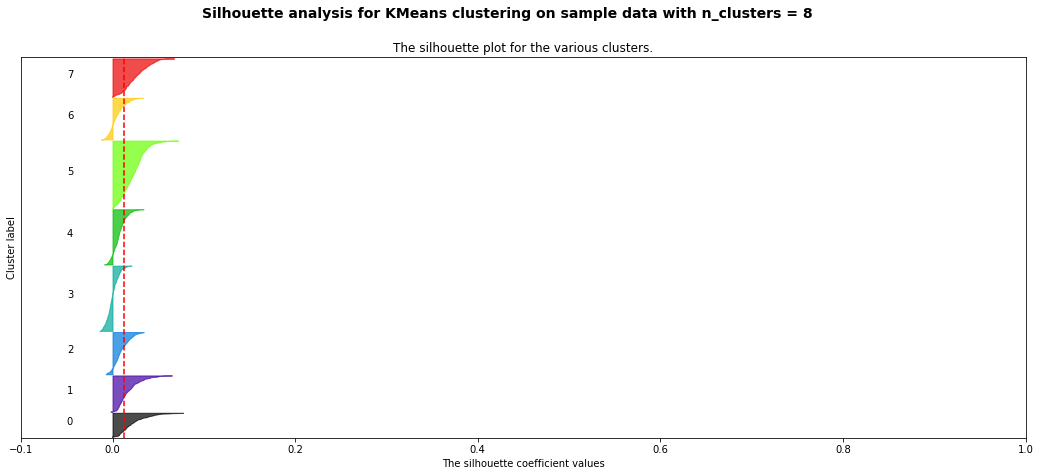

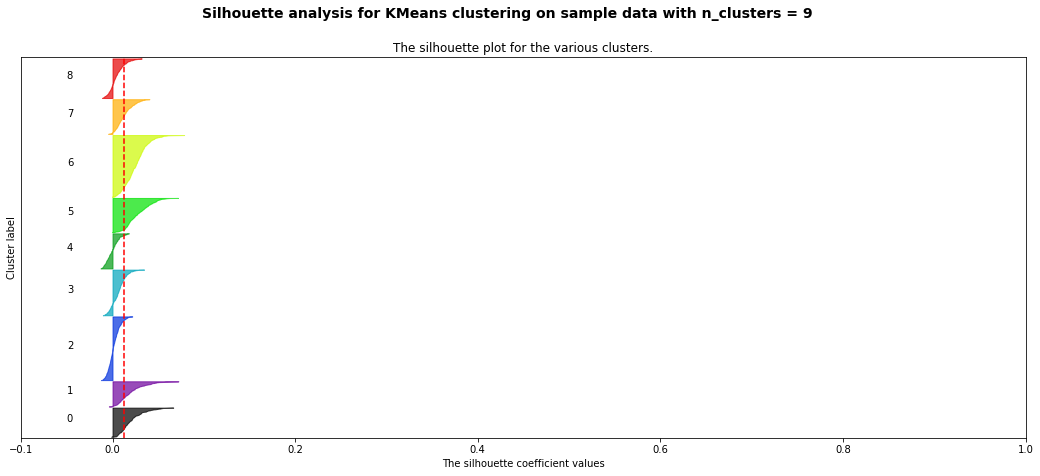

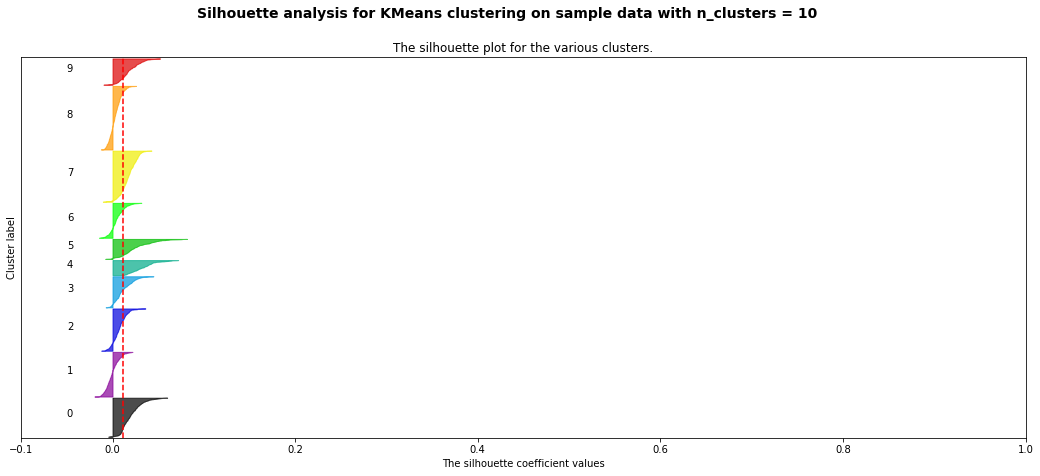

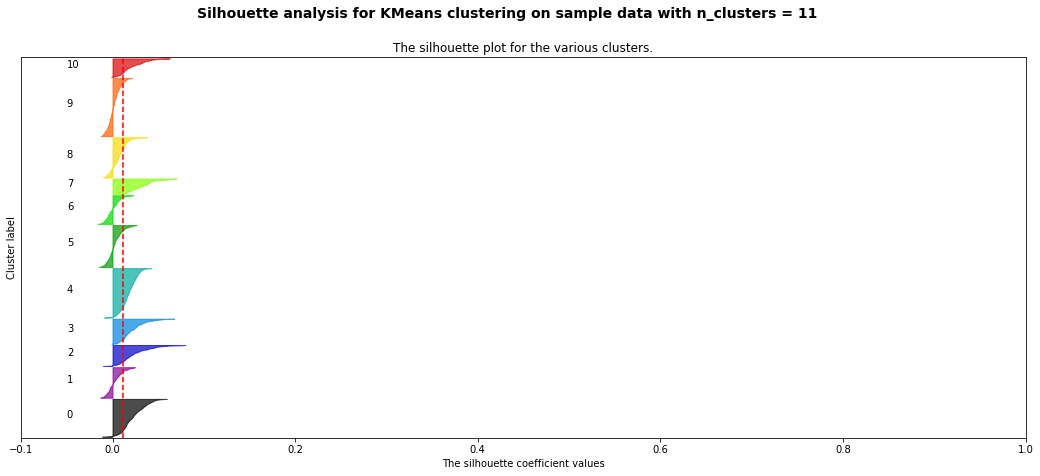

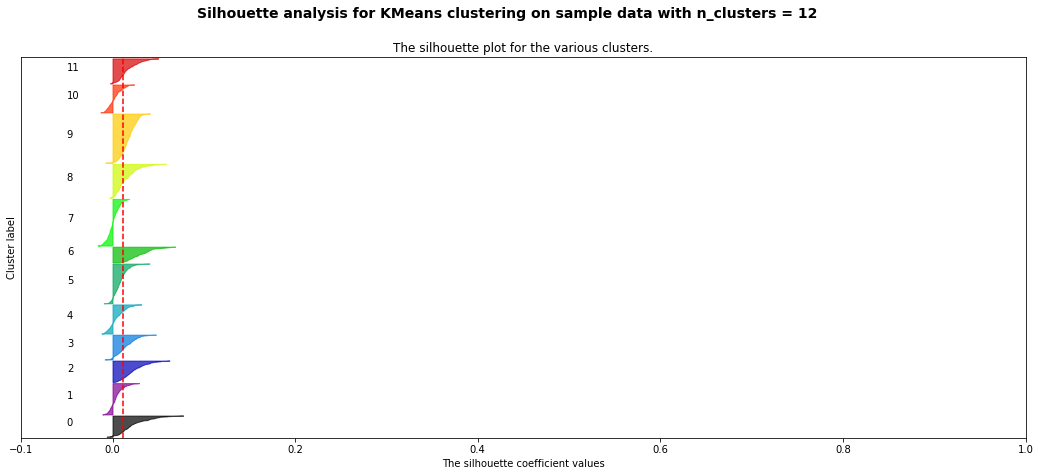

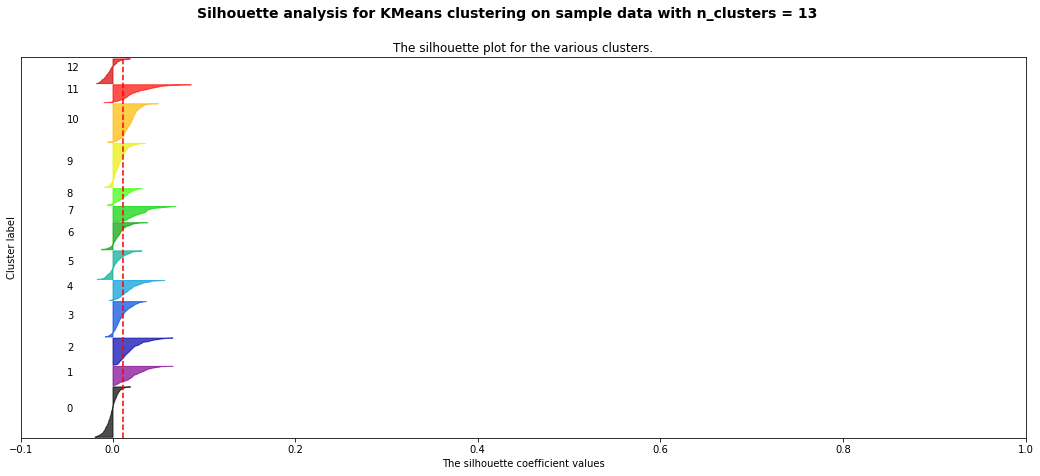

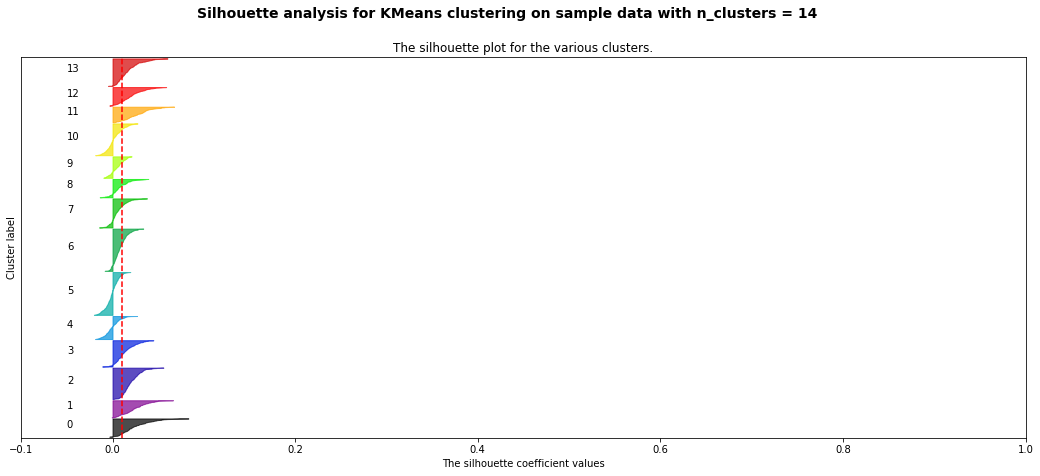

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

X = embeddings_norm
range_n_clusters = [int(k) for k in range(2, 15)]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Aside: soft k-means

In [226]:
def initialize_centers(x, num_k):
    N, D = x.shape
    centers = np.zeros((num_k, D))
    used_idx = []
    for k in range(num_k):
        idx = np.random.choice(N)
        while idx in used_idx:
            idx = np.random.choice(N)
        used_idx.append(idx)
        centers[k] = x[idx]
    return centers

def update_centers(x, r, K):
    N, D = x.shape
    centers = np.zeros((K, D))
    for k in range(K):
        centers[k] = r[:, k].dot(x) / r[:, k].sum()
    return centers

def square_dist(a, b):
    return (a - b) ** 2

def cost_func(x, r, centers, K):
    cost = 0
    for k in range(K):
        norm = np.linalg.norm(x - centers[k], 2)
        cost += (norm * np.expand_dims(r[:, k], axis=1) ).sum()
    return cost


def cluster_responsibilities(centers, x, beta):
    N, _ = x.shape
    K, D = centers.shape
    R = np.zeros((N, K))
    for n in range(N):        
        R[n] = np.exp(-beta * np.linalg.norm(centers - x[n], 2, axis=1)) 
    R /= R.sum(axis=1, keepdims=True)
    return R

def soft_k_means(x, K, max_iters=20, beta=1., eps=1e-5):
    centers = initialize_centers(x, K)
    prev_cost = 0
    for _ in range(max_iters):
        r = cluster_responsibilities(centers, x, beta)
        centers = update_centers(x, r, K)
        cost = cost_func(x, r, centers, K)
        if np.abs(cost - prev_cost) < eps:
            break
        prev_cost = cost
    return r

num_topics = 15
r = soft_k_means(embeddings_norm, num_topics, max_iters=20, beta=1.)
beta = r.T
beta = beta / beta.sum(axis=1, keepdims=True)

(array([ 33., 109., 292., 498., 740., 795., 691., 278.,  31.,   1.]),
 array([0.00028835, 0.00028835, 0.00028835, 0.00028835, 0.00028835,
        0.00028835, 0.00028835, 0.00028835, 0.00028835, 0.00028835,
        0.00028835]),
 <a list of 10 Patch objects>)

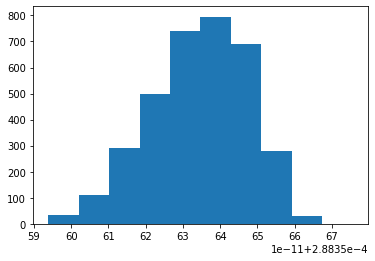

In [247]:
plt.hist(beta[0])

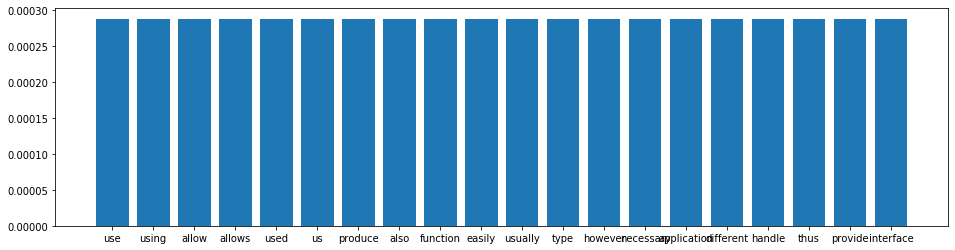

In [246]:
import numpy as np
import matplotlib.pyplot as plt

def extract_top_n_words(topic_distributions, dictionary, topic_id, top_n):
    top_n_words = [dictionary[np.argsort(topic_distributions[topic_id])[-i-1]] for i in range(top_n)]
    top_n_freqs = [np.sort(topic_distributions[topic_id])[-i-1] for i in range(top_n)]
    return top_n_words, top_n_freqs

topic_id = 14
top_n = 20
top_n_words, top_n_freqs = extract_top_n_words(beta, vocab, topic_id, top_n)

plt.figure(figsize=(16, 4))
plt.bar(top_n_words, top_n_freqs)
plt.show()

In [ ]:
# TODO

# Pre-processing
## Stronger pre-processing: only keep nouns/adjs/verbs

# Word embeddings
## Test pre-trained word embeddings (en and fr)
## Better word embeddings: fastText, elmo, bert ?

# Models
## Improve LDA with HDP (no pre-defined nb of topics)
## Hierarchical Clustering (no pre-defined nb of topics)
## From word emb to doc dist: word movers' distance

# Eval
## Visualization/Eval tools for word embeddings

# Dynamic approaches
## d-LDA
## d-ETM
## sliding window
## dynamic word embeddings
## online k-means
## dynamic vis/eval tools